In [29]:
# lets get these analogues going!

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import sklearn
from sklearn import cluster
from eofs.standard import Eof
from scipy.cluster.vq import vq
print('libraries loaded')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

libraries loaded


In [3]:
# note this takes around a minute to load in 

dataset = Dataset('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/Data/European_MSLP_and_MSLP_anomaly_data.nc')
ERA5_MSLP_anom  = dataset.variables['MSLP_anom'][:]
lons = dataset.variables['lon'][:]
lats = dataset.variables['lat'][:]
dataset.close()

print(np.shape(ERA5_MSLP_anom))

(42, 365, 149, 229)


(4560, 14)


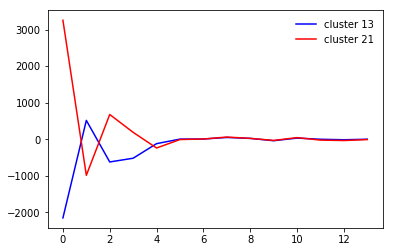

In [16]:
# load in the Prinpipal components and the cluster numbers

pcNEOFS = np.load('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1_accompanying_PCs.npy')

print(np.shape(pcNEOFS))
cluster_numbers = np.load('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1.npy')


#find the PC centroids
cluster_mean_centroids = np.zeros([30,14])

for clust_i in range(0,30):
    args_list = np.where(cluster_numbers == clust_i)
    #print(args_list)
    #print(np.shape(args_list))
    
    data_we_need = pcNEOFS[args_list[0],:]
    cluster_centroid = np.mean(data_we_need,axis=0)
    cluster_mean_centroids[clust_i,:] = cluster_centroid
    
    
plt.plot(cluster_mean_centroids[13,:],color='blue',label='cluster 13')
plt.plot(cluster_mean_centroids[21,:],color='red',label='cluster 21')
plt.legend(frameon=False)
plt.show()

In [12]:
# reshape the MSLP anom into [time,lat*lon]

# take final four years.
# Take Jan-Mar and concatenate  Dec onto the end of it
DJFM_MSLP = np.concatenate((ERA5_MSLP_anom[38:42,0:90,:,:],ERA5_MSLP_anom[38:42,335:365,:,:]),axis=1)
print(np.shape(DJFM_MSLP))

#reshape into 2d array for creation of EOFS in next step
reshaped_MSLP_anom = np.reshape(DJFM_MSLP,(4*120,len(lats)*len(lons)))


print(np.shape(reshaped_MSLP_anom))

(4, 120, 149, 229)
(480, 34121)


In [13]:
# create the EOFs
print('set up solver')
solver = Eof(reshaped_MSLP_anom)
print('calculating EOFs')

set up solver
calculating EOFs


In [18]:
print('extracting Principal components')
pcNEOFS_val_period = solver.pcs(npcs=14)
print('we have PCs')
print(np.shape(pcNEOFS_val_period))

extracting Principal components
we have PCs
(480, 14)


In [21]:
# now we have the Prinipcal components then lets 
code_book = cluster_mean_centroids
features = pcNEOFS_val_period

assignments_val_period,dist_val_period = vq(features,code_book)


Text(0, 0.5, 'Number of Occurences')

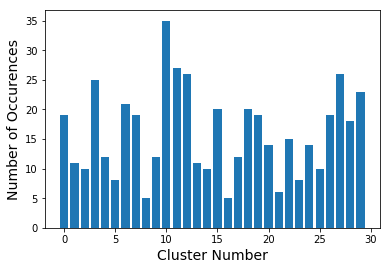

In [24]:
a,b = np.histogram(assignments_val_period,bins=np.linspace(0,30,31))
plt.bar(b[0:len(a)],a)
plt.xlabel('Cluster Number',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)


In [26]:
cluster_mean_centroids_val_period = np.zeros([30,len(lats),len(lons)])

for clust_i in range(0,30):
    args_list = np.where(assignments_val_period == clust_i)
    #print(args_list)
    #print(np.shape(args_list))
    
    data_we_need = reshaped_MSLP_anom[args_list[0],:]
    data_we_need_reshaped = np.reshape(data_we_need,(len(args_list[0]),len(lats),len(lons)))
    cluster_centroid = np.mean(data_we_need_reshaped,axis=0)
    cluster_mean_centroids_val_period[clust_i,:,:] = cluster_centroid

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


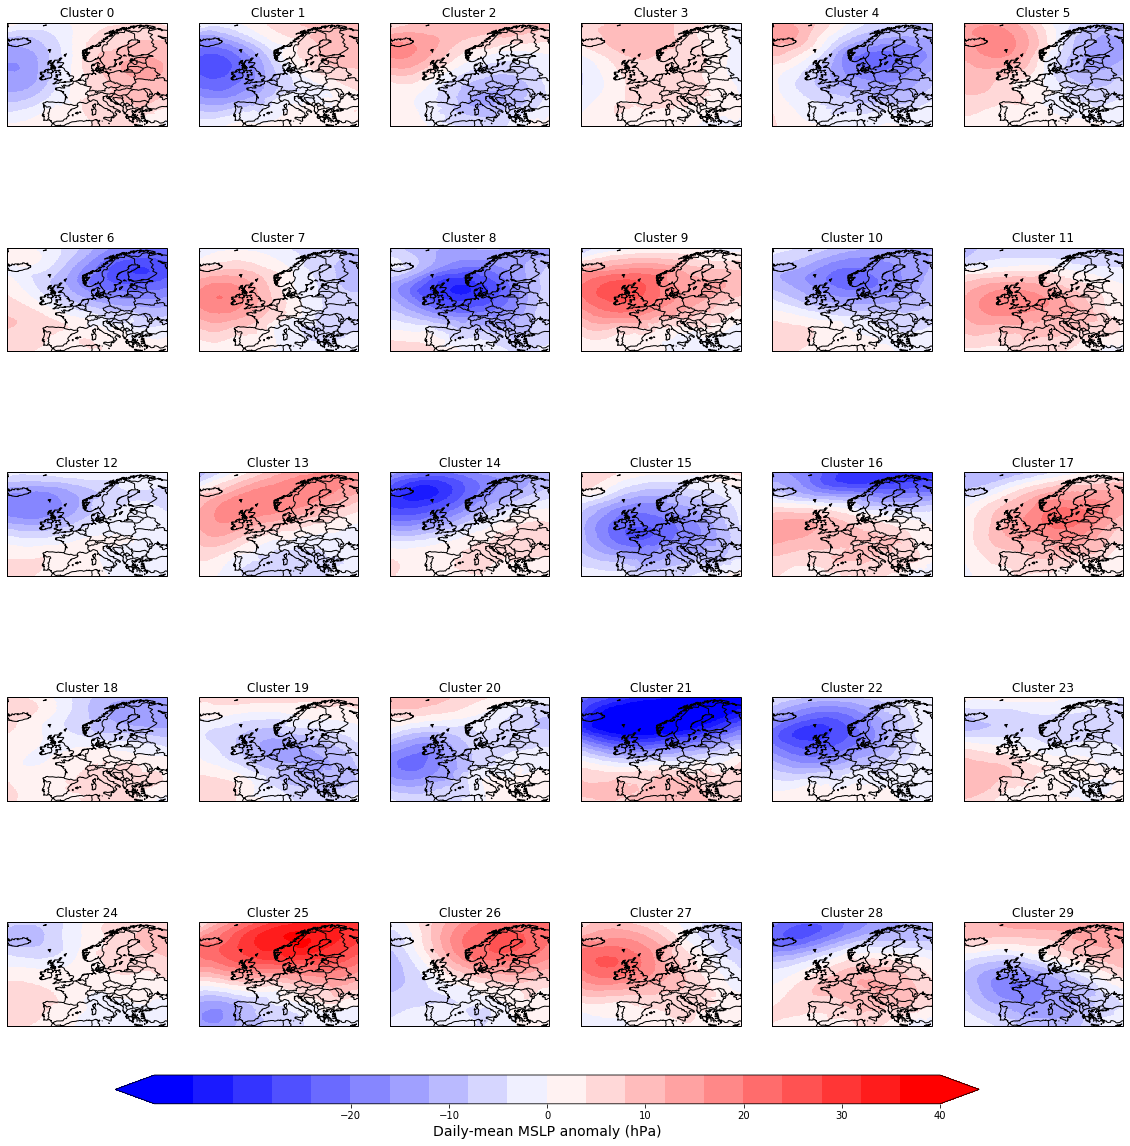

In [28]:
# Spatial plot of the cluster data to check the EOFS/PCs are all the right way up, including the sampling unvertainty i'm happy with this. 
gridded_lons,gridded_lats = np.meshgrid(lons,lats)

# setup colorbar
bounds = np.linspace(-40,40,21)
cmap = plt.cm.bwr
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
# setup plot
fig = plt.figure(figsize=(20,20))
for i in range(0,5):
    print(i)
    ax1 = fig.add_subplot(5,6,i+1,projection=ccrs.PlateCarree())
    cs = plt.pcolor(gridded_lons, gridded_lats, cluster_mean_centroids_val_period[i,:,:],cmap =cmap,norm=norm,transform=ccrs.PlateCarree())
    plt.title('Cluster ' + str(i),fontsize=12)
    ax1.coastlines(resolution='50m')
    ax1.add_feature(cartopy.feature.BORDERS)
    

ax2 = fig.add_axes([0.2,0.1,0.6,0.02])    
cb = mpl.colorbar.ColorbarBase(ax2,cmap=cmap,norm=norm,orientation='horizontal',extend='both',ticks=[-40.-30,-20,-10,0,10,20,30,40])
cb.set_label('Daily-mean MSLP anomaly (hPa)',fontsize=14)
plt.show()

In [32]:
np.save('DJFM_cluster_assignment_2017_to_2020_with_30_clusters_v1.npy',assignments_val_period)
np.save('DJFM_cluster_assignment_2017_to_2020_with_30_clusters_v1_accompanying_PCs.npy',pcNEOFS_val_period)


In [34]:
print(np.shape(assignments_val_period))

(480,)
